In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install POT

In [99]:
from CausalBenchmark.parameters import build_parameters_from_specification, DEFAULT_PARAMETER_PATH, build_parameters_from_metric_levels
from CausalBenchmark.constants import Constants
from CausalBenchmark.data_generation import DataGeneratingProcessWrapper
from CausalBenchmark.utilities import generate_random_covariates, normalize_covariate_data
from CausalBenchmark.utilities import extract_treat_and_control_data
from CausalBenchmark.data_metrics import calculate_data_metrics

In [100]:
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [101]:
covar_data = generate_random_covariates(n_covars = 12)
covar_data = normalize_covariate_data(covar_data)

In [127]:
dgp_params = build_parameters_from_metric_levels({
    Constants.MetricNames.TREATMENT_NONLINEARITY: Constants.MetricLevels.HIGH
})

In [130]:
dgp_wrapper = DataGeneratingProcessWrapper(
    parameters=dgp_params, source_covariate_data=covar_data)

dgp_wrapper.sample_dgp()

_ = dgp_wrapper.generate_data()

obs = dgp_wrapper.get_observed_data()
oracle = dgp_wrapper.get_oracle_data()
Y_t, Y_c = extract_treat_and_control_data(obs["Y"], obs["T"])
ATE_true = np.mean(oracle["TE"])
ATE_est = np.mean(Y_t) - np.mean(Y_c)
np.abs(ATE - ATE_est)

0.2509491311583538

## Metrics

In [8]:
def run(dgp_params, observation_spec,
        n_trials=10, n_covars=20, n_observations=250,
        verbose=False):
    results = defaultdict(lambda: defaultdict(list))
    for i in range(n_trials):
        if verbose:
            clear_output()
            print("Trials run:", i+1)
        results
        covar_data = generate_random_covariates(n_covars, n_observations)
        covar_data = normalize_covariate_data(covar_data)

        dgp_wrapper = DataGeneratingProcessWrapper(
            parameters=dgp_params, source_covariate_data=covar_data)
        dgp_wrapper.sample_dgp()

        observed_covariate_data, observed_outcome_data, oracle_covariate_data, oracle_outcome_data = dgp_wrapper.generate_data()
        metrics = calculate_data_metrics(
            observed_covariate_data, observed_outcome_data,
            oracle_covariate_data, oracle_outcome_data,
            observation_spec=observation_spec)
        
        for metric, measures in observation_spec.items():
            for measure in measures:
                res = metrics[metric][measure]
                results[metric][measure].append(res)
    
    if verbose:
        for metric, measures in results.items():
            for measure, result_data in measures.items():
                print(f"{metric} {measure}:")
                print("min", round(np.min(result_data), 3), end=" ")
                print("mean:", round(np.mean(result_data), 3), end=" ")
                print("max", round(np.max(result_data), 3))
                print("-------------\n\n")
        
    return results

In [74]:
def analyze_metric_measures_across_levels(
    metrics_and_measures,
    n_trials=20, n_covars=10):
    levels = [
        Constants.MetricLevels.LOW,
        Constants.MetricLevels.MEDIUM,
        Constants.MetricLevels.HIGH,
    ]

    results = defaultdict(lambda: defaultdict(dict))
    max_measure_count = 0
    for metric, measures in metrics_and_measures.items():
        print(f"\nRunning for {metric}. Level: ", end=" ")
        if len(measures) > max_measure_count:
            max_measure_count = len(measures)

        # Construct observation list of measures.
        observation_list = { metric: measures }

        # Run trials at all levels of metric.
        for level in levels:
            print(level, end=" ")
            dgp_params = build_parameters_from_metric_levels({
                metric: level
            })

            res = run(dgp_params, observation_list,
                      n_trials=n_trials, n_covars=n_covars)
            
            for measure, values in res[metric].items():
                results[metric][measure][level] = values
    
    return results

def plot_metric_measure_analysis(results):
    level_colors = ["g", "b", "y"]
    mean_color = "r"
    for metric, measures in results.items():
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{metric}")
        plt.tight_layout()

        for measure_num, (measure_name, measure_values) in enumerate(measures.items()):
            plt.subplot(1, max_measure_count, 1 + measure_num)
            plt.title(f"{measure_name}")
            for level_num, level in enumerate(levels):
                level_values = measure_values[level]

                # Find quartile values in data
                quartiles = np.percentile(
                    level_values,
                    [25, 50, 75],
                    interpolation = 'midpoint')

                # Prepare plotting data
                x = level_num+1
                y_median = quartiles[1]
                y_mean = np.mean(level_values)
                err = np.array([
                    [y_median - quartiles[0]],
                    [quartiles[2] - y_median]
                ])

                # Plot
                color = level_colors[level_num]
                plt.xlim((0, max_measure_count+1))
                plt.scatter(x, y_median, label=level, color=color)
                plt.scatter(x, y_mean, color=mean_color)
                plt.errorbar(x, y_median, err, color=color)

            plt.legend()

        plt.show()


Running for OUTCOME_NONLINEARITY. Level:  LOW MEDIUM HIGH 
Running for TREATMENT_NONLINEARITY. Level:  LOW MEDIUM HIGH 
Running for PERCENT_TREATED. Level:  LOW MEDIUM HIGH 
Running for BALANCE. Level:  LOW MEDIUM HIGH 
Running for ALIGNMENT. Level:  LOW MEDIUM HIGH 
Running for TE_HETEROGENEITY. Level:  LOW MEDIUM HIGH 

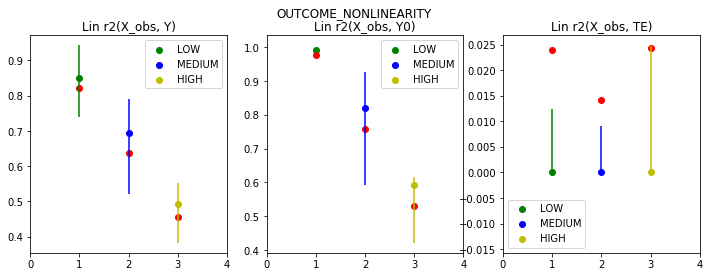

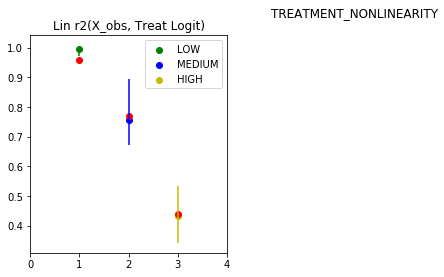

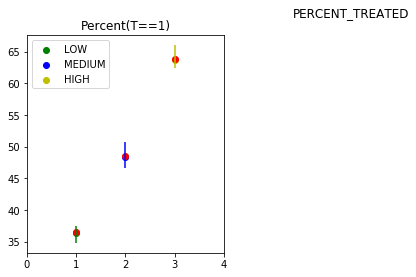

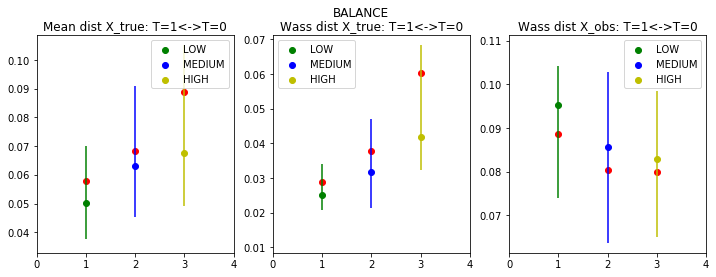

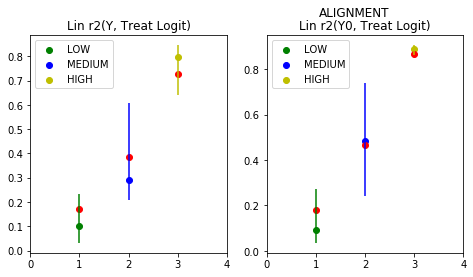

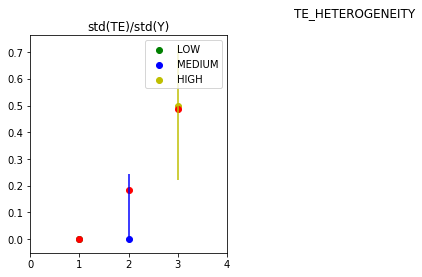

In [97]:
metrics_and_measures = {
    Constants.MetricNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_obs, Y0)",
        "Lin r2(X_obs, TE)"
    ],
    Constants.MetricNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)"
    ],
    Constants.MetricNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
#     Constants.MetricNames.OVERLAP: [
#         "NN dist X_obs: T=1<->T=0",
#         "NN dist X_true: T=1<->T=0"
#     ],
    Constants.MetricNames.BALANCE: [
        "Mean dist X_true: T=1<->T=0",
        "Wass dist X_true: T=1<->T=0",
        "Wass dist X_obs: T=1<->T=0",
        "Naive TE"
    ],
    Constants.MetricNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.MetricNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

results = analyze_metric_measures_across_levels(
    metrics_and_measures, n_trials=30, n_covars=10)
plot_metric_measure_analysis(results)

In [138]:
balance_metric_and_measures = {
    Constants.MetricNames.BALANCE: [
        "Naive TE"
    ]
}
metric_analysis = analyze_metric_measures_across_levels(
    balance_metric_and_measures,
    n_trials=20,
    n_covars=15)


Running for BALANCE. Level:  LOW MEDIUM HIGH 

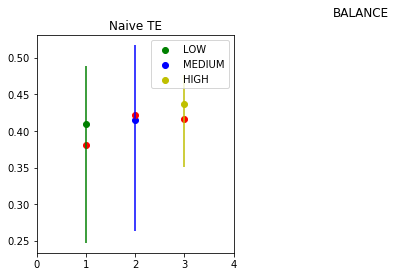

In [139]:
plot_metric_measure_analysis(metric_analysis)